## Plan
1. Read labelled corpus of words and their corresponding language (MSA or TND)
2. Split the data
3. Build character-ngram based language model of MSA words
4. Use MSA language model to build a word-level language classifier for MSA vs. TND

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import KneserNeyInterpolated
from nltk.util import ngrams

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Load word data from file

In [4]:
filename = '../../results/Arabic_words_corpus_final.csv'
df = pd.read_csv(filename, names=['word','lang_label'],header=None)
df.head()

,word,lang_label
0,آئ,MSA
1,آب,MSA
2,آباء,MSA
3,آبائه,MSA
4,آبائهم,MSA


In [5]:
msa_words_list = df.loc[df.lang_label=="MSA",'word'].tolist()
tnd_words_list = df.loc[df.lang_label=="TN",'word'].tolist()
len(msa_words_list),len(tnd_words_list)

(46895, 787)

In [6]:
msa_words_list[0:5]

['آئ', 'آب', 'آباء', 'آبائه', 'آبائهم']

In [7]:
tnd_words_list[0:5]

['اتفوه', 'اتفووه', 'احشم', 'احنا', 'اخخ']

## Split data into train and test sets
- 75% - 25% split of the data.
- the training data will be used to build the language model and calibrate (tune) the threshold of the language classifier.
- the test data will be used to evaluate the performance of this language classifier.

In [46]:
msa_words_train,msa_words_test = train_test_split(msa_words_list, test_size=0.25, random_state=123)
len(msa_words_train), len(msa_words_test)

(35171, 11724)

In [9]:
tnd_words_train,tnd_words_test = train_test_split(tnd_words_list, test_size=0.25, random_state=3456)
len(tnd_words_train), len(tnd_words_test)

(590, 197)

*******

## Build language model of MSA words

In [10]:
# set the order of the desired ngram model
N = 3

### Padding words

In order to build an N-gram character-level language model, we need to first extract all character ngrams of length N from each training word. Furthermore, in order to capture the beginning and end of a word, we pad it on the left and the right with N-2 special characters, called *pad symbols*. 

For example, the padded form of the word 'جرح' is :

`left_pad_symbol, left_pad_symbol, ح , ر , ج , right_pad_symbol, right_pad_symbol`

Hence, the extracted 3-grams of this word are:

`left_pad_symbol, left_pad_symbol, ج`

`left_pad_symbol, ر , ج`

`ح , ر, right_pad_symbol`

`ح, right_pad_symbol, right_pad_symbol`


**Important remark**: Because Arabic is a right-to-left language, pad symbols must also be 'right-to-left characters'. This has to do with the way Python (anf programming languages in general) handles right-to-left text (vs. the default left-to-right text.


In [11]:
# Modified version of padded_everygram_pipeline that passes optional arguments to pad_both_ends.
# Source: https://repos.lsv.uni-saarland.de/christine_schaefer/sopro-chatbot-ws2019/blob/5dee69e4bd0c95a1b3cb63196669f910de2b8da0/language_models.py

from functools import partial
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten

# I chose punctuation marks from the Arabic character set as pad symbols.
# See above remark about choice of pad symbols for right-to-left languages
LEFT_PAD_SYMBOL="\u0602"
RIGHT_PAD_SYMBOL="\u0603"

## These pad symbols will NOT work for Arabic text.
#BAD_LEFT_PAD_SYMBOL="<"
#BAD_RIGHT_PAD_SYMBOL=">"


def my_padded_everygram_pipeline(order, text, pad_left=True, pad_right=True, left_pad_symbol=LEFT_PAD_SYMBOL, right_pad_symbol=RIGHT_PAD_SYMBOL):
    """
    Creates two iterators:
    - sentences padded and turned into sequences of `nltk.util.everygrams`
    - sentences padded as above and chained together for a flat stream of words

    :param order: Largest ngram length produced by `everygrams`.
    :param text: Text to iterate over. Expected to be an iterable of sentences, i.e. Iterable[Iterable[str]]
    :return: iterator over text as ngrams, iterator over text as vocabulary data
    """
    padding_fn = partial(pad_both_ends, n=order, pad_left=pad_left, pad_right=pad_right, left_pad_symbol=left_pad_symbol, right_pad_symbol=right_pad_symbol)
    return (
        (everygrams(list(padding_fn(sent)), max_len=order) for sent in text),
        flatten(map(padding_fn, text)),
    )

# unit test:
text = [['the', 'cats', 'and', 'the', 'dogs'], ['the', 'cat', 'is', 'on', 'the', 'mat']]
text = ['استحالة', 'اشباه', 'جرح']
ngram_sentences_, padded_sentences_ = my_padded_everygram_pipeline(2, text)

print('ngrams:')
for x in ngram_sentences_:
    print(list(x))
    print()
print('#############')
print('padded sentences:')
list(padded_sentences_)

ngrams:
[('\u0602',), ('ا',), ('س',), ('ت',), ('ح',), ('ا',), ('ل',), ('ة',), ('\u0603',), ('\u0602', 'ا'), ('ا', 'س'), ('س', 'ت'), ('ت', 'ح'), ('ح', 'ا'), ('ا', 'ل'), ('ل', 'ة'), ('ة', '\u0603')]

[('\u0602',), ('ا',), ('ش',), ('ب',), ('ا',), ('ه',), ('\u0603',), ('\u0602', 'ا'), ('ا', 'ش'), ('ش', 'ب'), ('ب', 'ا'), ('ا', 'ه'), ('ه', '\u0603')]

[('\u0602',), ('ج',), ('ر',), ('ح',), ('\u0603',), ('\u0602', 'ج'), ('ج', 'ر'), ('ر', 'ح'), ('ح', '\u0603')]

#############
padded sentences:


['\u0602',
 'ا',
 'س',
 'ت',
 'ح',
 'ا',
 'ل',
 'ة',
 '\u0603',
 '\u0602',
 'ا',
 'ش',
 'ب',
 'ا',
 'ه',
 '\u0603',
 '\u0602',
 'ج',
 'ر',
 'ح',
 '\u0603']

In [12]:
# preprocess the training data for language modeling: pad it then flatten it
ngram_sentences, padded_sentences = my_padded_everygram_pipeline(N, msa_words_train)

In [13]:
# train a smoothed N-gram language model
lm1 = KneserNeyInterpolated(N)
lm1.fit(ngram_sentences, padded_sentences)

In [14]:
print(lm1.counts)

<NgramCounter with 3 ngram orders and 898245 ngrams>


In [15]:
lm1.counts[list('في')]

FreqDist({'\u0603': 94, 'ة': 63, 'ن': 42, 'ا': 41, 'ر': 31, 'د': 26, 'ل': 20, 'ف': 18, 'ق': 17, 'ت': 17, ...})

In [16]:
lm1.perplexity([('ف', 'ي')])

9.545368211123893

### Use trained language model to *score* words
Calculate *perplexity score* of each word in input corpus based on the trained language model.

In [17]:
# Wrapper function

def preprocess_and_score_word(lm,word):
    n = lm.order
    return lm.perplexity( ngrams(word, n, pad_left = True, pad_right = True, left_pad_symbol=LEFT_PAD_SYMBOL, right_pad_symbol=RIGHT_PAD_SYMBOL) )

#unit test
x = 'ماشية'
preprocess_and_score_word(lm1,x)

9.684777854248615

In [18]:
words = msa_words_train + msa_words_test + tnd_words_train + tnd_words_test
labels = ['MSA']*len(msa_words_list) + ['TND']*len(tnd_words_list)
in_train = [True]*len(msa_words_train) + [False]*len(msa_words_test) + [True]*len(tnd_words_train) + [False]*len(tnd_words_test)
len(words),len(labels),len(in_train)

(47682, 47682, 47682)

In [19]:
word_scoring_df = pd.DataFrame({'word':words, 'lang_label':labels, 'in_train':in_train})
word_scoring_df['word_len'] = word_scoring_df.word.map(len)
word_scoring_df['lm1_score'] = word_scoring_df.word.map(lambda w: preprocess_and_score_word(lm1,w))
word_scoring_df = word_scoring_df.set_index('word')
word_scoring_df.head()

,lang_label,in_train,word_len,lm1_score
word,,,,
الاجنبية,MSA,True,8,5.325849
رحل,MSA,True,3,9.097862
وقالت,MSA,True,5,8.671401
وحدهم,MSA,True,5,6.274267
ويعلق,MSA,True,5,10.025276


In [20]:
# top 5 scoring words
word_scoring_df.sort_values(by='lm1_score',ascending=True).head()

,lang_label,in_train,word_len,lm1_score
word,,,,
الات,MSA,False,4,3.179515
المؤسسة,MSA,False,7,3.233863
الية,MSA,False,4,3.337778
المرات,MSA,True,6,3.373424
ال,MSA,False,2,3.426526


In [21]:
# 5 lowest scoring words
word_scoring_df.sort_values(by='lm1_score',ascending=True).tail()

,lang_label,in_train,word_len,lm1_score
word,,,,
اأ,MSA,False,2,inf
ضؤل,MSA,False,3,inf
تحذث,MSA,False,4,inf
كئيبة,MSA,False,5,inf
الكآبة,MSA,False,6,inf


### Exploratory analysis of distribution of word scores
This is helpful for understanding/interpreting the performance of the language classifier in the next section.

#### Infinite scores

In [22]:
# number of infinite scores
(word_scoring_df.lm1_score==np.inf).sum()

14

In [23]:
# association between a word's score being finite and being in the training set of the LM
pd.crosstab(word_scoring_df.lm1_score!=np.inf,(word_scoring_df.in_train)&(word_scoring_df.lang_label=="MSA"))

col_0,False,True
lm1_score,,
False,14,0
True,12497,35171


In [24]:
# association between a non training word's score being finite and its language label
idx = (word_scoring_df.in_train)&(word_scoring_df.lang_label=="MSA")
pd.crosstab(word_scoring_df[~idx].lm1_score!=np.inf,word_scoring_df[~idx].lang_label)

lang_label,MSA,TND
lm1_score,,
False,12,2
True,11712,785


*Remarks and conclusions:*
- all words in the training set of the model have finite scores (as expected, otherwise there is a bug in LM training).
- about 50% of TND words have infnite scores, compared to only 25% of MSA words.

#### Distribution of scores of training and test words by language label

In [25]:
# Select finite scores only because plotting functions cannot handle (ii.e. crash!) infinite scores

word_scoring_df_finite = word_scoring_df.loc[word_scoring_df.lm1_score!=np.inf].copy()
word_scoring_df.shape,word_scoring_df_finite.shape

((47682, 4), (47668, 4))

In [26]:
# utility function
def foo1(x):
    if x.lang_label=="MSA" and x.in_train:
        return 'MSA_train'
    elif x.lang_label=="MSA" and x.in_train==False:
        return 'MSA_test'
    elif x.lang_label=="TND" and x.in_train:
        return 'TND_train'
    else:
        return 'TND_test'

word_scoring_df_finite['train_lang_label'] = word_scoring_df_finite.apply(foo1, axis=1)

**Plot distribution as boxplots**


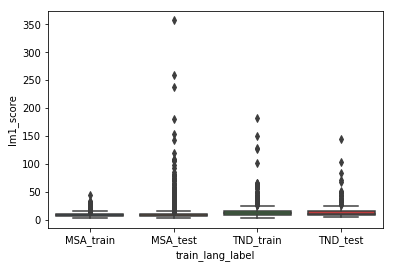

In [27]:
sns.boxplot(x='train_lang_label',y='lm1_score', data=word_scoring_df_finite)

**Plot distribution as empirical PDFs**

(i.e. normalized histograms)

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

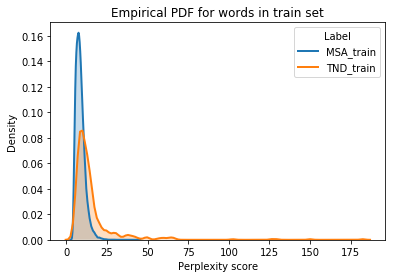

In [28]:
# Distribution of scores for words that will be used to calibrate the decision threshold

for lab in ['MSA_train', 'TND_train']:
    sns.distplot(word_scoring_df_finite.lm1_score[word_scoring_df_finite.train_lang_label==lab], hist=False, kde=True, 
                 label = lab, bins=20, 
                 hist_kws={'edgecolor':'black'}, kde_kws = {'shade': True, 'linewidth': 2})

# Plot formatting
plt.legend(prop={'size': 10}, title = 'Label')
plt.title('Empirical PDF for words in train set')
plt.xlabel('Perplexity score')
plt.ylabel('Density')
#plt.axes([-1,50,0,0.5])

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

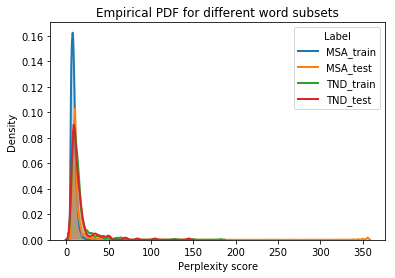

In [29]:
# Distribution of scores of test words (after threshold calibration)

for lab in word_scoring_df_finite.train_lang_label.unique():
    sns.distplot(word_scoring_df_finite.lm1_score[word_scoring_df_finite.train_lang_label==lab], hist=False, kde=True, 
                 label = lab, bins=20, 
                 hist_kws={'edgecolor':'black'}, kde_kws = {'shade': True, 'linewidth': 2})

# Plot formatting
plt.legend(prop={'size': 10}, title = 'Label')
plt.title('Empirical PDF for different word subsets')
plt.xlabel('Perplexity score')
plt.ylabel('Density')

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

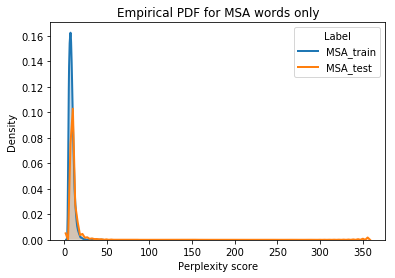

In [61]:
for lab in ['MSA_train', 'MSA_test']:
    sns.distplot(word_scoring_df_finite.lm1_score[word_scoring_df_finite.train_lang_label==lab], hist=False, kde=True, 
                 label = lab, bins=20, 
                 hist_kws={'edgecolor':'black'}, kde_kws = {'shade': True, 'linewidth': 2})

# Plot formatting
plt.legend(prop={'size': 10}, title = 'Label')
plt.title('Empirical PDF for MSA words only')
plt.xlabel('Perplexity score')
plt.ylabel('Density')


C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

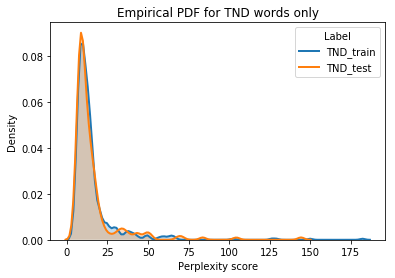

In [60]:
for lab in ['TND_train', 'TND_test']:
    sns.distplot(word_scoring_df_finite.lm1_score[word_scoring_df_finite.train_lang_label==lab], hist=False, kde=True, 
                 label = lab, bins=20, 
                 hist_kws={'edgecolor':'black'}, kde_kws = {'shade': True, 'linewidth': 2})

# Plot formatting
plt.legend(prop={'size': 10}, title = 'Label')
plt.title('Empirical PDF for TND words only')
plt.xlabel('Perplexity score')
plt.ylabel('Density')


C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

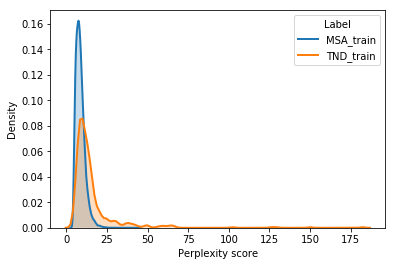

In [62]:
for lab in ['MSA_train', 'TND_train']:
    sns.distplot(word_scoring_df_finite.lm1_score[word_scoring_df_finite.train_lang_label==lab], hist=False, kde=True, 
                 label = lab, bins=20, 
                 hist_kws={'edgecolor':'black'}, kde_kws = {'shade': True, 'linewidth': 2})

# Plot formatting
plt.legend(prop={'size': 10}, title = 'Label')
plt.xlabel('Perplexity score')
plt.ylabel('Density')


C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

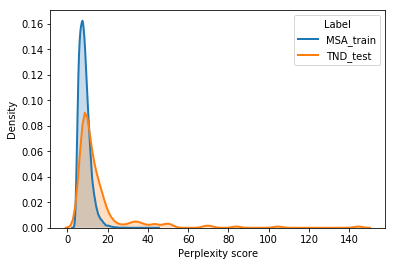

In [63]:
for lab in ['MSA_train', 'TND_test']:
    sns.distplot(word_scoring_df_finite.lm1_score[word_scoring_df_finite.train_lang_label==lab], hist=False, kde=True, 
                 label = lab, bins=20, 
                 hist_kws={'edgecolor':'black'}, kde_kws = {'shade': True, 'linewidth': 2})

# Plot formatting
plt.legend(prop={'size': 10}, title = 'Label')
plt.xlabel('Perplexity score')
plt.ylabel('Density')


*Remarks and Conclusions:*
- The score distributions for words of the same language are highly consistent between training and test sets.
- The score distributions for MSA and TND words are not well-separated (large overlap among them), therefore it is unlikely that we will be able to separate/classify words of these two languages based only on their perplexity scores (as we will see in the next section).

****

## Use MSA language model to build a MSA vs. TND word-level language classifier

We aim to solve a constrained version of the general language identification problem -- with the set of possible languages being limited to **only two languages**: MSA and TND.

In other words, given an arbitrary word, we want to classify it as either MSA or TND.

We propose an *anomaly detection* approach to this problem. Our language classifier consists of the simple decision rule: 

                if perplexity_score(word) < t then return MSA else return TND

where $perplexity\_score(word)$ is calculated using our trained MSA language model, and $t$ is a fixed threshold value (i.e. a *hyperparameter* of this method). 

### Hyperparameter tuning
- We will calibrate (tune) the value of the threshold parameter $t$ of our classifier by finding the value that **maximizes** classification performance.
- Since the training data is so imbalanced (there are more than 20 times MSA words than TND words), we shall use the **average F1 score** as a measure of model performance during the tuning (instead of the usual classification accuracy measure).

In [30]:
threshold_calibration_df = word_scoring_df.loc[word_scoring_df.in_train==True]
threshold_calibration_df.shape,word_scoring_df.shape

((35761, 4), (47682, 4))

In [31]:
threshold_calibration_df.lang_label.value_counts()

MSA    35171
TND      590
Name: lang_label, dtype: int64

In [32]:
thresholds = np.arange(1,100,step=1)
eval_df = pd.DataFrame(index=thresholds)
eval_df.index.name = 'Score_Threshold'
true_lang_label = (threshold_calibration_df.lang_label=="TND").map({True:1, False:0})

In [33]:
for Score_Threshold in thresholds:
    pred_lang_label = threshold_calibration_df.lm1_score.map(lambda x: x>Score_Threshold).map({True:1, False:0})
    eval_df.loc[Score_Threshold,'f1_TND'] = metrics.f1_score(true_lang_label, pred_lang_label)
    eval_df.loc[Score_Threshold,'f1_MSA'] = metrics.f1_score(1-true_lang_label, 1-pred_lang_label)

eval_df.loc[:,'f1_avg'] = (eval_df.f1_TND+eval_df.f1_MSA)/2

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
eval_df.head()

,f1_TND,f1_MSA,f1_avg
Score_Threshold,,,
1,0.032461,0.000000,0.016231
2,0.032461,0.000000,0.016231
3,0.032461,0.000000,0.016231
4,0.032519,0.003689,0.018104
5,0.033725,0.089818,0.061772


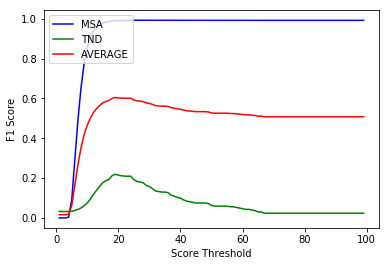

In [47]:
x = np.asarray(eval_df.index)
plt.plot(x,eval_df.f1_MSA,'b-', label="MSA")
plt.plot(x,eval_df.f1_TND,'g-',label='TND')
plt.plot(x,eval_df.f1_avg,'r-',label='AVERAGE')
plt.xlabel('Score Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [50]:
# Best threshold value: the one that yields highest F1 score
print("Threshold value that yields best average F1 score:",eval_df.f1_avg.idxmax())
print("")
print("Summary of performance on the training set using this threshold:")
print(eval_df.loc[eval_df.f1_avg.idxmax()])

Threshold value that yields best average F1 score: 19

Summary of performance on the training set using this threshold:
f1_TND    0.219327
f1_MSA    0.989816
f1_avg    0.604571
Name: 19, dtype: float64


### Evaluate classifier performance on test set

In [37]:
Best_Score_Threshold = eval_df.f1_avg.idxmax()
Best_Score_Threshold

19

In [38]:
performance_testing_df = word_scoring_df.loc[word_scoring_df.in_train==False]
performance_testing_df.lang_label.value_counts()

MSA    11724
TND      197
Name: lang_label, dtype: int64

In [39]:
test_true_lang_label = performance_testing_df.lang_label=="TND"
test_pred_lang_label = performance_testing_df.lm1_score.map(lambda x: x>Best_Score_Threshold)

In [40]:
# Area Under the ROC Curve (AUC)
test_pred_score = performance_testing_df.lm1_score.map(lambda x: 1000 if x==np.inf else x)
metrics.roc_auc_score(test_true_lang_label, test_pred_score)

0.6937065189718864

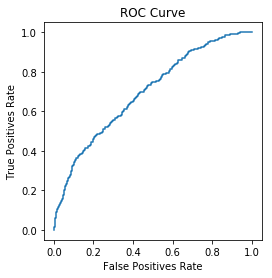

In [41]:
# ROC Curve

fpr,tpr,thresholds = metrics.roc_curve(test_true_lang_label.map({True:"TND", False:"MSA"}), test_pred_score, pos_label="TND")
plt.plot(fpr,tpr)
plt.axis([0,1,0,1])
plt.axis('square')
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.title('ROC Curve')
plt.show()

In [42]:
# Precision and Recall

print(metrics.classification_report(test_true_lang_label.map({True:"TND", False:"MSA"}), test_pred_lang_label.map({True:"TND", False:"MSA"})))

              precision    recall  f1-score   support

         MSA       0.99      0.96      0.97     11724
         TND       0.06      0.15      0.08       197

   micro avg       0.94      0.94      0.94     11921
   macro avg       0.52      0.55      0.53     11921
weighted avg       0.97      0.94      0.96     11921



In [49]:
# Average F1 Score

test_f1_tnd = metrics.f1_score(test_true_lang_label, test_pred_lang_label)
test_f1_msa = metrics.f1_score(~test_true_lang_label, ~test_pred_lang_label)
test_f1_avg = (test_f1_msa+test_f1_tnd)/2

print("Performance on the test set:")
print("MSA F1 score:", test_f1_msa)
print("TND F1 score:", test_f1_tnd)
print("Average F1 score:", test_f1_avg)

Performance on the test set:
MSA F1 score: 0.9712332915170653
TND F1 score: 0.08275862068965517
Average F1 score: 0.5269959561033603


In [44]:
# Confusion matrix

test_true_lang_label.name = 'true_label'
test_pred_lang_label.name = 'predicted_label'
pd.crosstab(test_true_lang_label.map({True:"TND", False:"MSA"}), test_pred_lang_label.map({True:"TND", False:"MSA"}))

pred_label,MSA,TND
true_label,,
MSA,11226,498
TND,167,30
